# Importing and Installing Libraries Used Globally

In [1]:
import os
import glob
import random
import gc
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Configs

In [2]:
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Dataset / model hyperparams (user-provided)
NUM_CLASSES = 4  # background, road, lm_dashed, lm_solid
IMG_H, IMG_W = 256, 448  # height x width (user: 256x448)
BATCH_SIZE = 8
KFOLDS = 5

# k-fold config
KF_EPOCHS = 100
KF_PATIENCE = 10

# final full-train config
FINAL_EPOCHS = 500
FINAL_PATIENCE = 50

Device: cuda


In [3]:
# IMAGE_DIR = "/kaggle/input/v1-300-tt/v1-300-tt.voc/train/images"  
# MASK_DIR  = "/kaggle/input/v1-300-tt/v1-300-tt.voc/train/masks"

TRAIN_IMAGE_DIR = "/kaggle/input/v6-300-tvt/v6-300-tvt.voc/train/images"  
TRAIN_MASK_DIR  = "/kaggle/input/v6-300-tvt/v6-300-tvt.voc/train/masks"
VAL_IMAGE_DIR = "/kaggle/input/v6-300-tvt/v6-300-tvt.voc/valid/images"  
VAL_MASK_DIR  = "/kaggle/input/v6-300-tvt/v6-300-tvt.voc/valid/masks"

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Utils Function

In [4]:
def get_image_mask_pairs(image_dir, mask_dir):
    img_paths = sorted(glob.glob(os.path.join(image_dir, "*.*")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.*")))
    img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in img_paths}
    mask_map = {os.path.splitext(os.path.basename(p))[0]: p for p in mask_paths}
    keys = sorted(list(set(img_map.keys()) & set(mask_map.keys())))
    images = [img_map[k] for k in keys]
    masks = [mask_map[k] for k in keys]
    return images, masks

In [5]:
def get_transforms(size_h=IMG_H, size_w=IMG_W):
    train_transform = A.Compose([
        A.Resize(height=size_h, width=size_w),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(height=size_h, width=size_w),
        A.Normalize(),
        ToTensorV2()
    ])
    return train_transform, val_transform

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        assert len(image_paths) == len(mask_paths)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # grayscale mask (0..N)
        # Safety checks
        if mask is None:
            raise RuntimeError(f"Mask not loaded: {self.mask_paths[idx]}")
        if img is None:
            raise RuntimeError(f"Image not loaded: {self.image_paths[idx]}")

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]
            mask = aug["mask"]
        # mask should be LongTensor with shape [H, W], not one-hot
        mask = torch.as_tensor(mask, dtype=torch.long)
        return img, mask

# DeepLabV3+ Architecture

In [7]:
# Function to set batch normalization layers to evaluation mode
def set_bn_eval(module):
    if isinstance(module, nn.BatchNorm2d):
        module.eval()

class ECALayer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.global_avgpool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

class CBAMLayer(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAMLayer, self).__init__()
        self.channel_attention = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False), nn.ReLU(inplace=True), nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False), nn.Sigmoid())
        self.spatial_attention = nn.Sequential(nn.Conv2d(2, 1, 7, padding=3, bias=False), nn.Sigmoid())
    def forward(self, x):
        ca = self.channel_attention(x); x = x * ca
        sa_input = torch.cat([torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]], dim=1); sa = self.spatial_attention(sa_input); x = x * sa
        return x

class FCALayer(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(FCALayer, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.global_avg_pool(x); y = self.fc1(y); y = self.relu(y); y = self.fc2(y); y = self.sigmoid(y)
        return x * y

# --- Backbone dan Modul DeepLabV3+ (Sesuai dengan Notebook Training Anda) ---
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18Backbone, self).__init__()
        self.resnet18 = timm.create_model('resnet18', pretrained=pretrained, features_only=True, out_indices=(0, 1, 2, 3))
        self.resnet18.apply(set_bn_eval)
        self.eca = ECALayer(channel=256, k_size=3)
        self.se = SEBlock(in_channels=256)
        self.cbam = CBAMLayer(in_channels=256)
    def forward(self, x):
        features = self.resnet18(x)
        low_level_feature = features[1]
        high_level_feature = self.eca(features[-1])
        high_level_feature = self.se(high_level_feature)
        high_level_feature = self.cbam(high_level_feature)
        return {'low_level': low_level_feature, 'out': high_level_feature, 'features': features}

class AtrousSeparableConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(AtrousSeparableConvolution, self).__init__()
        self.body = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias, groups=in_channels), nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias))
    def forward(self, x):
        return self.body(x)

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        size = x.shape[-2:]; x = self.avg_pool(x); x = self.conv(x)
        if x.shape[-1] > 1 and x.shape[-2] > 1: x = self.bn(x)
        x = self.relu(x); return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = [nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))]
        for rate in atrous_rates: modules.append(AtrousSeparableConvolution(in_channels, out_channels, kernel_size=3, padding=rate, dilation=rate, bias=False))
        modules.append(ASPPPooling(in_channels, out_channels)); self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(nn.Conv2d(len(modules) * out_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True), nn.Dropout(0.1))
    def forward(self, x):
        res = [conv(x) for conv in self.convs]; res = torch.cat(res, dim=1); return self.project(res)

class FEM(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FEM, self).__init__()
        self.convs = nn.ModuleList([nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)) for in_channels in in_channels_list])
        self.output_conv = nn.Sequential(nn.Conv2d(len(in_channels_list) * out_channels, out_channels, kernel_size=1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
    def forward(self, features):
        res = []; target_size = features[-1].shape[2:]
        for conv, feature in zip(self.convs, features): feature = F.interpolate(feature, size=target_size, mode='bilinear', align_corners=False); res.append(conv(feature))
        res = torch.cat(res, dim=1); return self.output_conv(res)

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate):
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential(nn.Conv2d(low_level_channels, 48, 1, bias=False), nn.BatchNorm2d(48), nn.ReLU(inplace=True))
        self.cbam = CBAMLayer(in_channels=256)
        self.aspp = ASPP(in_channels, 256, aspp_dilate)
        self.cbam_decoder = CBAMLayer(in_channels=304)
        self.fca = FCALayer(in_channels=304)
        self.classifier = nn.Sequential(AtrousSeparableConvolution(304, 256, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.Conv2d(256, num_classes, 1))
    def forward(self, feature, afm_features=None):
        low_level_feature = self.project(feature['low_level'])
        output_feature = self.cbam(feature['out'])
        output_feature = self.aspp(output_feature)
        if afm_features is not None:
            output_feature += afm_features
        output_feature = F.interpolate(output_feature, size=low_level_feature.shape[2:], mode='bilinear', align_corners=False)
        concatenated_features = torch.cat([low_level_feature, output_feature], dim=1)
        concatenated_features = self.cbam_decoder(concatenated_features)
        concatenated_features = F.interpolate(concatenated_features, scale_factor=4, mode='bilinear', align_corners=False)
        concatenated_features = self.fca(concatenated_features)
        return self.classifier(concatenated_features)
        
class DeepLabV3Plus(nn.Module):
    def __init__(self, backbone, num_classes, output_stride=8):
        super(DeepLabV3Plus, self).__init__()
        atrous_rates = [12, 24, 36] if output_stride == 8 else [6, 12, 18]
        self.backbone = backbone
        self.head = DeepLabHeadV3Plus(in_channels=256, low_level_channels=64, num_classes=num_classes, aspp_dilate=atrous_rates)
        self.fem = FEM(in_channels_list=[64, 64, 128, 256], out_channels=256)
    def forward(self, x):
        backbone_features = self.backbone(x)
        fem_features = self.fem(backbone_features['features'])
        output = self.head({'low_level': backbone_features['low_level'], 'out': backbone_features['out']}, afm_features=fem_features)
        output = F.interpolate(output, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return output, fem_features

# Dataset Preparation Class

# Performance Metrics

# Evaluation Metrics

In [8]:
def compute_mean_iou(preds, target, n_classes=NUM_CLASSES):
    ious = []
    preds_flat = preds.view(-1)
    target_flat = target.view(-1)
    for cls in range(n_classes):
        pred_inds = preds_flat == cls
        target_inds = target_flat == cls
        if target_inds.long().sum().item() == 0:
            ious.append(np.nan)
            continue
        intersect = torch.logical_and(pred_inds, target_inds).sum().item()
        union = torch.logical_or(pred_inds, target_inds).sum().item()
        ious.append((intersect + 1e-10) / (union + 1e-10))
    return float(np.nanmean(ious))

def compute_mean_dice(preds, target, n_classes=NUM_CLASSES):
    dices = []
    preds_flat = preds.view(-1)
    target_flat = target.view(-1)
    for cls in range(n_classes):
        pred_inds = preds_flat == cls
        target_inds = target_flat == cls
        if target_inds.long().sum().item() == 0:
            dices.append(np.nan)
            continue
        tp = torch.logical_and(pred_inds, target_inds).sum().item()
        fp = torch.logical_and(pred_inds, ~target_inds).sum().item()
        fn = torch.logical_and(~pred_inds, target_inds).sum().item()
        dice = (2 * tp + 1e-10) / (2 * tp + fp + fn + 1e-10)
        dices.append(dice)
    return float(np.nanmean(dices))

def compute_pixel_accuracy(preds, target):
    # preds: [B,H,W] class indices, target: [B,H,W]
    valid = (target >= 0)
    correct = (preds == target) & valid
    return float(correct.sum().item()) / max(1.0, valid.sum().item())

## Loss

In [9]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, class_weights=None):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        # use smp DiceLoss only if available, else implement a simple one
        try:
            import segmentation_models_pytorch as smp
            self.dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
            self.use_smp = True
        except Exception:
            self.use_smp = False

    def forward(self, logits, target):
        ce_loss = self.ce(logits, target)
        if self.use_smp:
            dice_loss = self.dice(logits, target)
        else:
            # simple soft-dice surrogate: convert logits->probs and compute multiclass dice
            probs = F.softmax(logits, dim=1)
            target_onehot = F.one_hot(target, NUM_CLASSES).permute(0,3,1,2).float()
            intersection = (probs * target_onehot).sum(dim=(2,3))
            union = probs.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
            dice_score = (2 * intersection + 1e-7) / (union + 1e-7)
            dice_loss = 1.0 - dice_score.mean()
        return self.alpha * ce_loss + self.beta * dice_loss

# Training Preparation

In [10]:
def train_one_epoch(model, loader, optimizer, criterion, scaler=None):
    model.train()
    running_loss = 0.0
    n_samples = 0
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            logits, _ = model(imgs)  # logits shape [B,C,H,W]
            loss = criterion(logits, masks)
        if device == 'cuda' and scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        bs = imgs.size(0)
        running_loss += loss.item() * bs
        n_samples += bs
    return running_loss / max(1, n_samples)

def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    n_samples = 0
    iou_list = []
    acc_list = []
    dice_list = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            logits, _ = model(imgs)
            loss = criterion(logits, masks)
            bs = imgs.size(0)
            running_loss += loss.item() * bs
            n_samples += bs
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            # compute metrics per batch
            for p, t in zip(preds, masks):
                iou_list.append(compute_mean_iou(p.unsqueeze(0), t.unsqueeze(0)))
                acc_list.append(compute_pixel_accuracy(p.unsqueeze(0), t.unsqueeze(0)))
                dice_list.append(compute_mean_dice(p.unsqueeze(0), t.unsqueeze(0)))
    mean_loss = running_loss / max(1, n_samples)
    mean_iou = float(np.nanmean(iou_list))
    mean_acc = float(np.nanmean(acc_list))
    mean_dice = float(np.nanmean(dice_list))
    return mean_loss, mean_iou, mean_acc, mean_dice

In [11]:
def run_kfold_training():
    images, masks = get_image_mask_pairs(IMAGE_DIR, MASK_DIR)
    if len(images) == 0:
        raise RuntimeError("No image-mask pairs found. Check IMAGE_DIR and MASK_DIR paths.")
    print("Found pairs:", len(images))

    # Naive stratification label: mode pixel value in mask
    labels = []
    for mp in masks:
        mm = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        labels.append(int(np.bincount(mm.flatten()).argmax()))

    train_t, val_t = get_transforms()

    skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)

    fold_metrics = []
    fold_csv_paths = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(images, labels)):
        print(f"\n=== Fold {fold} ===")
        train_imgs = [images[i] for i in train_idx]
        train_masks = [masks[i] for i in train_idx]
        val_imgs = [images[i] for i in val_idx]
        val_masks = [masks[i] for i in val_idx]

        train_ds = SegmentationDataset(train_imgs, train_masks, transform=train_t)
        val_ds = SegmentationDataset(val_imgs, val_masks, transform=val_t)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

        # new model for each fold
        backbone = ResNet18Backbone(pretrained=True)
        model = DeepLabV3Plus(backbone=backbone, num_classes=NUM_CLASSES).to(device)
        # optimizer + scaler
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
        criterion = CombinedLoss(alpha=1.0, beta=1.0)

        best_val_loss = float("inf")
        patience_counter = 0

        # prepare CSV logging for this fold
        rows = []
        csv_path = f"results/fold_{fold}.csv"
        fold_csv_paths.append(csv_path)

        for epoch in range(KF_EPOCHS):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler if device=='cuda' else None)
            val_loss, val_iou, val_acc, val_dice = validate_one_epoch(model, val_loader, criterion)

            # we can compute train metrics on train set quickly or set NaN to save time — compute train_iou/acc/dice on a small subset for speed
            train_loss_quick = train_loss
            # Log
            row = {
                "fold": fold, "epoch": epoch,
                "train_loss": train_loss_quick, "val_loss": val_loss,
                "val_iou": val_iou, "val_acc": val_acc, "val_dice": val_dice
            }
            rows.append(row)
            # print
            print(f"Fold {fold} Epoch {epoch:03d} | train_loss={train_loss_quick:.4f} val_loss={val_loss:.4f} val_iou={val_iou:.4f} val_acc={val_acc:.4f} val_dice={val_dice:.4f}")

            # checkpoint by val_loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"models/fold_{fold}_best.pth")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= KF_PATIENCE:
                    print(f"Early stopping fold {fold} at epoch {epoch} (patience {KF_PATIENCE})")
                    break

        # save CSV for fold
        pd.DataFrame(rows).to_csv(csv_path, index=False)
        fold_metrics.append({
            "fold": fold,
            "best_val_loss": best_val_loss,
            "last_epoch": epoch
        })
        # cleanup
        del model, backbone, optimizer, scaler, criterion
        torch.cuda.empty_cache()
        gc.collect()

    # write summary CSV
    summary_df = pd.DataFrame(fold_metrics)
    summary_csv = "results/summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    print("K-Fold finished. Summary saved to", summary_csv)
    return fold_csv_paths

In [12]:
def plot_results(fold_csv_paths):
    # read CSVs and plot (Loss, IoU, Acc, Dice)
    all_dfs = [pd.read_csv(p) for p in fold_csv_paths]
    metrics = [("train_loss","val_loss"), ("val_acc",), ("val_iou",), ("val_dice",)]
    # Plot Loss separately (train & val)
    plt.figure(figsize=(10,6))
    for idx, df in enumerate(all_dfs):
        plt.plot(df["epoch"], df["train_loss"], alpha=0.3, label=f"fold{idx} train" if idx==0 else None)
        plt.plot(df["epoch"], df["val_loss"], alpha=0.6, label=f"fold{idx} val" if idx==0 else None)
    # compute mean-val-loss per epoch (align by epoch index; different folds may stop earlier — pad with NaN)
    max_epoch = max(df["epoch"].max() for df in all_dfs)
    epoch_grid = np.arange(0, max_epoch+1)
    val_loss_matrix = []
    for df in all_dfs:
        arr = np.full(epoch_grid.shape, np.nan)
        arr[df["epoch"].values.astype(int)] = df["val_loss"].values
        val_loss_matrix.append(arr)
    val_loss_matrix = np.vstack(val_loss_matrix)
    mean_val = np.nanmean(val_loss_matrix, axis=0)
    std_val  = np.nanstd(val_loss_matrix, axis=0)
    plt.plot(epoch_grid, mean_val, color="black", linewidth=2, label="mean val loss")
    plt.fill_between(epoch_grid, mean_val-std_val, mean_val+std_val, color="gray", alpha=0.2)
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train/Val Loss per Fold and Mean (val)"); plt.legend()
    plt.show()

    # Plot IoU, Accuracy, Dice (val)
    fig, axs = plt.subplots(1,3, figsize=(18,5))
    for metric, ax, title in zip(["val_iou","val_acc","val_dice"], axs, ["mIoU","Pixel Acc","Dice"]):
        # build matrix
        M = []
        for df in all_dfs:
            arr = np.full(epoch_grid.shape, np.nan)
            if metric in df.columns:
                arr[df["epoch"].values.astype(int)] = df[metric].values
            M.append(arr)
        M = np.vstack(M)
        mean_m = np.nanmean(M, axis=0)
        std_m = np.nanstd(M, axis=0)
        ax.plot(epoch_grid, mean_m, linewidth=2)
        ax.fill_between(epoch_grid, mean_m-std_m, mean_m+std_m, alpha=0.2)
        ax.set_title(title); ax.set_xlabel("Epoch"); ax.set_ylabel(title)
    plt.show()

In [13]:
def denormalize(img_tensor):
    """Undo ImageNet normalization for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3,1,1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img

@torch.no_grad()
def visualize_sample_predictions(model, loader, num_samples=5):
    model.eval()
    device = next(model.parameters()).device
    shown = 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models returning (out, aux)
        preds = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            if shown >= num_samples:
                return

            img = denormalize(images[i].cpu())
            mask = masks[i].cpu()
            pred = preds[i].cpu()

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img.permute(1, 2, 0))
            axes[0].set_title("Input Image")
            axes[1].imshow(mask, cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred, cmap='gray')
            axes[2].set_title("Predicted Mask")
            for ax in axes: ax.axis("off")
            plt.tight_layout()
            plt.show()

            shown += 1


In [14]:
def run_final_full_training():
    print("🚀 Starting Final Full Training...")

    # --- Load datasets ---
    train_images, train_masks = get_image_mask_pairs(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR)
    val_images, val_masks = get_image_mask_pairs(VAL_IMAGE_DIR, VAL_MASK_DIR)

    train_t, val_t = get_transforms()

    train_ds = SegmentationDataset(train_images, train_masks, transform=train_t)
    val_ds = SegmentationDataset(val_images, val_masks, transform=val_t)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    # --- Model setup ---
    backbone = ResNet18Backbone(pretrained=True)
    model = DeepLabV3Plus(backbone=backbone, num_classes=NUM_CLASSES).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
    criterion = CombinedLoss(alpha=1.0, beta=1.0)

    # --- Training control ---
    best_val_loss = float("inf")
    patience_counter = 0
    rows = []

    print(f"Training on {len(train_ds)} images, validating on {len(val_ds)} images")

    for epoch in range(FINAL_EPOCHS):
        # --- Train one epoch ---
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion,
            scaler=scaler if device == 'cuda' else None
        )

        # --- Evaluate on train set (for metrics only) ---
        train_loss_eval, train_iou, train_acc, train_dice = validate_one_epoch(model, train_loader, criterion)

        # --- Validate ---
        val_loss, val_iou, val_acc, val_dice = validate_one_epoch(model, val_loader, criterion)

        # --- Log ---
        row = {
            "epoch": epoch,
            "train_loss": train_loss_eval,
            "train_iou": train_iou,
            "train_acc": train_acc,
            "train_dice": train_dice,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_acc": val_acc,
            "val_dice": val_dice
        }
        rows.append(row)

        print(
            f"Epoch {epoch:03d} | "
            f"Train L={train_loss_eval:.4f} IoU={train_iou:.4f} Acc={train_acc:.4f} Dice={train_dice:.4f} || "
            f"Val L={val_loss:.4f} IoU={val_iou:.4f} Acc={val_acc:.4f} Dice={val_dice:.4f}"
        )

        # --- Early stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "models/final_best.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= FINAL_PATIENCE:
                print(f"🛑 Early stopping at epoch {epoch} (patience {FINAL_PATIENCE})")
                break

    # --- Save logs ---
    df = pd.DataFrame(rows)
    csv_path = "results/final_training.csv"
    df.to_csv(csv_path, index=False)
    print(f"✅ Training complete. Model saved to models/final_best.pth, logs to {csv_path}")

    # --- Plot metrics ---
    metrics = ["loss", "iou", "acc", "dice"]
    plt.figure(figsize=(12, 8))
    for i, m in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(df["epoch"], df[f"train_{m}"], label=f"Train {m.upper()}", linewidth=2)
        plt.plot(df["epoch"], df[f"val_{m}"], label=f"Val {m.upper()}", linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel(m.upper())
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Final Training Metrics", fontsize=16)
    plt.show()

    # --- Visualize 5 sample predictions ---
    visualize_sample_predictions(model, val_loader)

# Main Training Process

## Define Models Used

## Training Configurations

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Define Optimizers and Scheduler

🚀 Starting Final Full Training...


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Training on 206 images, validating on 68 images


/tmp/ipykernel_19/3594416193.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
/tmp/ipykernel_19/1821295333.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 000 | Train L=2.1785 IoU=0.4191 Acc=0.7206 Dice=0.4877 || Val L=2.1767 IoU=0.4522 Acc=0.7284 Dice=0.5225
Epoch 001 | Train L=1.8023 IoU=0.5019 Acc=0.9349 Dice=0.5400 || Val L=1.7927 IoU=0.5358 Acc=0.9374 Dice=0.5748
Epoch 002 | Train L=0.9691 IoU=0.5242 Acc=0.9628 Dice=0.5525 || Val L=0.9629 IoU=0.5547 Acc=0.9619 Dice=0.5855
Epoch 003 | Train L=0.7607 IoU=0.5351 Acc=0.9702 Dice=0.5590 || Val L=0.7563 IoU=0.5664 Acc=0.9694 Dice=0.5923
Epoch 004 | Train L=0.7126 IoU=0.5368 Acc=0.9703 Dice=0.5638 || Val L=0.7036 IoU=0.5741 Acc=0.9729 Dice=0.6006
Epoch 005 | Train L=0.6697 IoU=0.5537 Acc=0.9750 Dice=0.5814 || Val L=0.6728 IoU=0.5812 Acc=0.9738 Dice=0.6092
Epoch 006 | Train L=0.6438 IoU=0.5772 Acc=0.9762 Dice=0.6160 || Val L=0.6501 IoU=0.5963 Acc=0.9750 Dice=0.6304
Epoch 007 | Train L=0.6271 IoU=0.6011 Acc=0.9758 Dice=0.6530 || Val L=0.6378 IoU=0.6194 Acc=0.9733 Dice=0.6699
Epoch 008 | Train L=0.5949 IoU=0.6405 Acc=0.9785 Dice=0.7061 || Val L=0.6044 IoU=0.6608 Acc=0.9770 Dice=0.7245
E

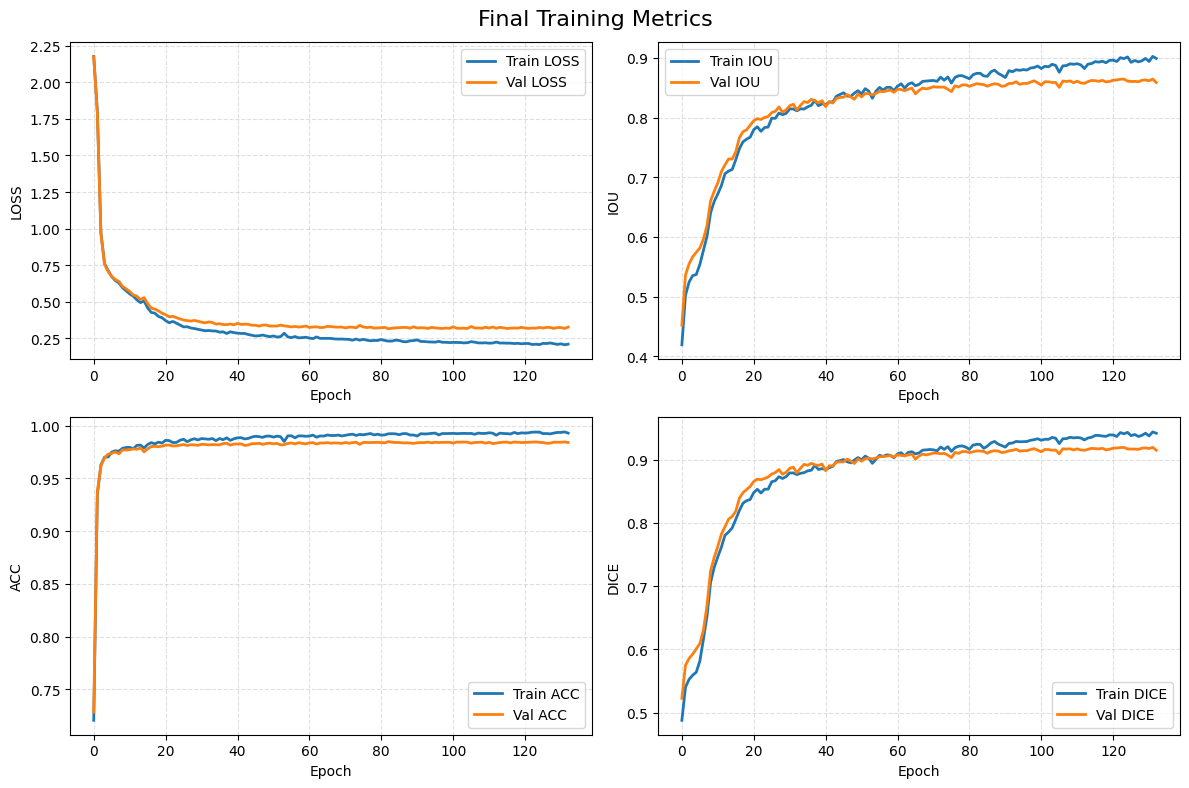

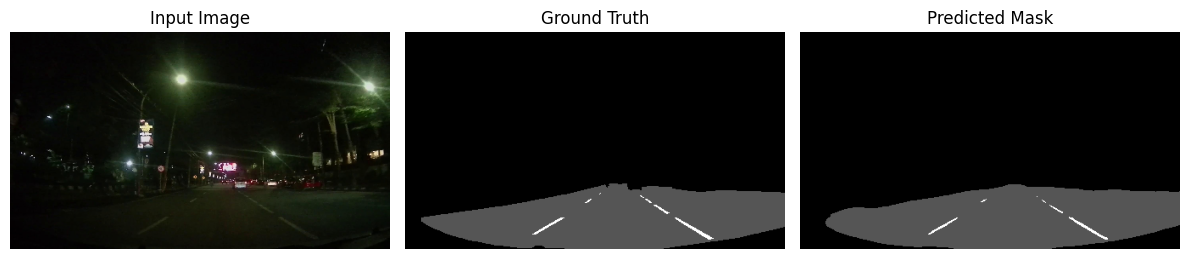

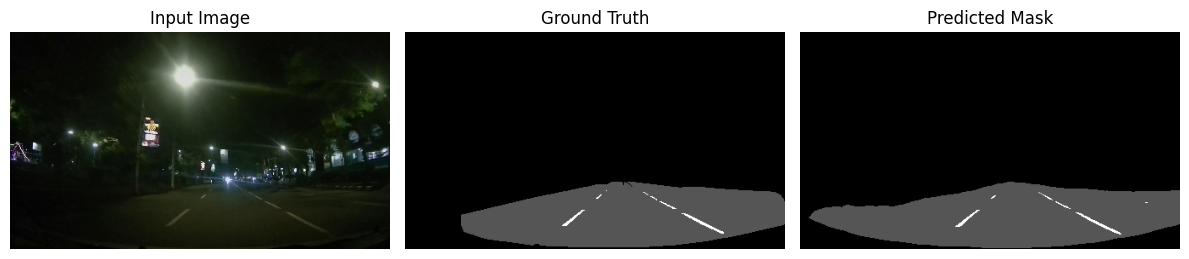

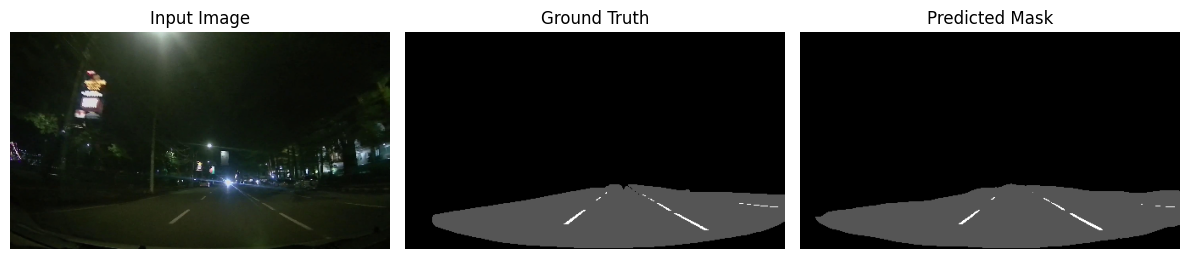

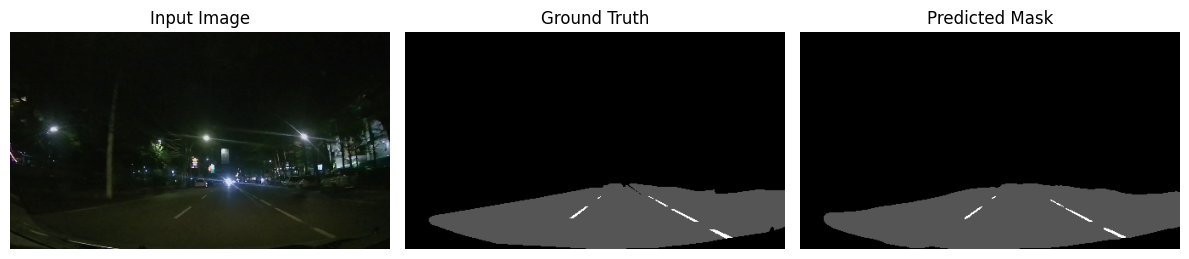

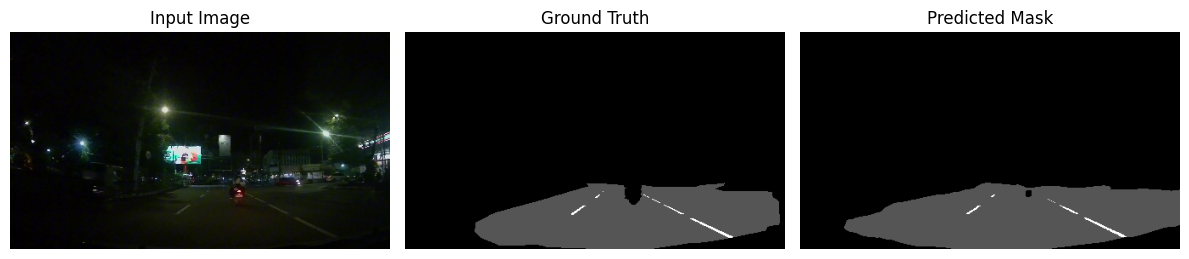

In [16]:
run_final_full_training()

In [17]:
# fold_csvs = run_kfold_training()
# plot_results(fold_csvs)